# Online political networks of Boulder
[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT)

## Import libraries

In [2]:
# Lets Jupyter Notebook display images in-line
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

# Import Twitter API wrapper
import twitter

# Import our helper libraries
import numpy as np
import pandas as pd
import networkx as nx

pd.options.display.max_columns = 100

# 
from datetime import datetime, timedelta
import json
import requests
from bs4 import BeautifulSoup
import time
from urllib.error import HTTPError
from urllib.parse import quote, unquote

In [3]:
def chunks(l, n=50):
    """
    Yield successive n-sized chunks from l.
    Adapted from: https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks    
    """
    for i in range(0, len(l), n):
        yield l[i:i + n]

## Configure API access

This will not work for you until you [set up your own Twitter application](https://developer.twitter.com/en/docs/twitter-api/getting-started/getting-access-to-the-twitter-api).

In [4]:
# Load my key information from disk
with open('twitter_v2_keys.json','r') as f:
    twitter_keys = json.load(f)

# Authenticate with the Twitter API using the twitter_keys dictionary
api = twitter.Twitter(
    auth = twitter.OAuth(
        token = twitter_keys['access_token'],
        token_secret = twitter_keys['access_token_secret'],
        consumer_key = twitter_keys['api_key'],
        consumer_secret = twitter_keys['api_key_secret']
    ),
)

## Define members and candidates

This is a hand-curated list based on information I could find from Twitter's search functionality.

In [5]:
members = {
    'Aaron Brockett': {'account_name':'AaronBrockett12'},
    'Rachel Friend': {'account_name':'rachelkfriend'},
    'Junie Joseph': {'account_name':'Junie4Boulder'},
    'Mirabai Nagle': {'account_name':None},
    'Adam Swtlik': {'account_name':'AdamSwetlik'},
    'Mark Wallach': {'account_name':None},
    'Sam Weaver': {'account_name':'sampweaver'},
    'Bob Yates': {'account_name':None},
    'Mary Young': {'account_name':'marydoloyoung'}}

candidates = {
    'Matt Benjamin': {'account_name':'MBforBoulder'},
    'Michael Christy': {'account_name':None},
    'Jaques Decalo': {'account_name':None},
    'Lauren Folkerts': {'account_name':'BoulderLauren4'},
    'Steven Rosenblum': {'account_name':None},
    'Nicole Speer': {'account_name':'NicoleKSpeer'},
    'David Takahaski': {'account_name':None},
    'Mark Wallach': {'account_name':None},
    'Dan Williams': {'account_name':'DanWilliams303'},
    'Tara Winer': {'account_name':'TaraWiner'}
}

## Get data about members and candidates accounts

For each member and candidate, retrieve their Twitter meta-data from the [GET users/lookup](https://developer.twitter.com/en/docs/twitter-api/v1/accounts-and-users/follow-search-get-users/api-reference/get-users-lookup) API endpoint.

In [ ]:
# For each member
for _name,_d in members.items():
    _account_name = _d['account_name']
    if _account_name is not None:
        
        # Look up their information
        _lookup = api.users.lookup(screen_name=_account_name)
        _d['account_id'] = _lookup[0]['id_str']
        _d['followers_count'] = _lookup[0]['followers_count']
        _d['friends_count'] = _lookup[0]['friends_count']
        _d['account_created'] = _lookup[0]['created_at']
        _d['statuses_count'] = _lookup[0]['statuses_count']

In [20]:
for _name,_d in candidates.items():
    _account_name = _d['account_name']
    if _account_name is not None:
        _lookup = api.users.lookup(screen_name=_account_name)
        _d['account_id'] = _lookup[0]['id_str']
        _d['followers_count'] = _lookup[0]['followers_count']
        _d['friends_count'] = _lookup[0]['friends_count']
        _d['account_created'] = _lookup[0]['created_at']
        _d['statuses_count'] = _lookup[0]['statuses_count']

## Get members' friends

For each member and candidate, retrieve their friend IDs from the [GET friends/ids](https://developer.twitter.com/en/docs/twitter-api/v1/accounts-and-users/follow-search-get-users/api-reference/get-friends-ids) API endpoint.

In [94]:
# Create an empty container
member_friend_ids = {}

In [ ]:
# For each member, get their friend IDs
for _name, _d in members.items():
    _account_name = _d['account_name']
    if _account_name is not None:
        _account_id = _d['account_id']
        if _account_id not in member_friend_ids:
            member_friend_ids[_account_id] = api.friends.ids(user_id=_account_id,count=5000)['ids']
        

In [98]:
# Save to disk
with open('member_friend_ids.json','w') as f:
    json.dump(member_friend_ids,f)

In [100]:
# Create an empty container
candidate_friend_ids = {}

In [102]:
# For each candidate, get their friend IDS
for _name, _d in candidates.items():
    _account_name = _d['account_name']
    if _account_name is not None:
        _account_id = _d['account_id']
        if _account_id not in candidate_friend_ids:
            try:
                candidate_friend_ids[_account_id] = api.friends.ids(user_id=_account_id,count=5000)['ids']
            except:
                pass

In [103]:
# Save to disk
with open('candidate_friend_ids.json','w') as f:
    json.dump(candidate_friend_ids,f)

## Repeats among friends

Identify repeated friends among the members and candidates.

In [106]:
# Load the data about members' and candidates' friends.

with open('member_friend_ids.json','r') as f:
    member_friend_ids = json.load(f)

with open('candidate_friend_ids.json','r') as f:
    candidate_friend_ids = json.load(f)

In [107]:
count_s = "There are {0:,} items"

# Count the number of unique friends of members
unique_member_friend_ids = set([_friend for _friend_id_l in member_friend_ids.values() for _friend in _friend_id_l])
print(count_s.format(len(unique_member_friend_ids)) + " in the members' friends")

# Count the number of unique friends of candidates
unique_candidate_friend_ids = set([_friend for _friend_id_l in candidate_friend_ids.values() for _friend in _friend_id_l])
print(count_s.format(len(unique_candidate_friend_ids)) + " in the candidates' friends")

# Combine both and count the unique friends of both
unique_combined_friend_ids = unique_member_friend_ids | unique_candidate_friend_ids
print(count_s.format(len(unique_combined_friend_ids)) + " in the both sets' friends")

There are 2,141 items in the members' friends
There are 1,159 items in the candidates' friends
There are 2,886 items in the both sets' friends


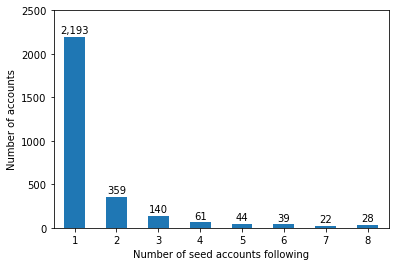

In [114]:
# Count the number of times an account was followed by a member of candidate
flattened_member_friends = [_friend for _friend_id_l in member_friend_ids.values() for _friend in _friend_id_l]
flattened_candidate_friends = [_friend for _friend_id_l in candidate_friend_ids.values() for _friend in _friend_id_l]
combined_friends_count = pd.Series(flattened_member_friends + flattened_candidate_friends).value_counts()

# Make a histogram of these counts
ax = combined_friends_count.value_counts().sort_index().plot.bar()
ax.set_ylim((0,2500))
ax.set_xlabel('Number of seed accounts following')
ax.set_ylabel('Number of accounts')
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
ax.set_facecolor('white')

for _x,_y in combined_friends_count.value_counts().sort_index().to_dict().items():
    ax.annotate(
        text = "{0:,}".format(_y),
        xy = (_x-1,_y+20),
        ha = 'center',
        va = 'bottom'
    )

plt.savefig('friend_count.png',dpi=300)

In [134]:
# Accounts that are friended by more than 1 account
gt1_friends = [str(i) for i in combined_friends_count[combined_friends_count > 1].index]

## Get friends info

For each of the seeds' friends, retrieve their Twitter meta-data from the [GET users/lookup](https://developer.twitter.com/en/docs/twitter-api/v1/accounts-and-users/follow-search-get-users/api-reference/get-users-lookup) API endpoint.

In [216]:
friends_lookup_l = []

for _chunk in chunks(gt1_friends,100):
    friends_lookup_l += api.users.lookup(user_id=",".join(_chunk))

In [219]:
friend_lookup_df_d = []

# Pull out relevant data
for _l in friends_lookup_l:
    _d = {}
    _d['id'] = _l['id_str']
    _d['name'] = _l['name']
    _d['screen_name'] = _l['screen_name']
    _d['location'] = _l['location']
    _d['description'] = _l['description']
    _d['protected'] = _l['protected']
    _d['followers_count'] = _l['followers_count']
    _d['friends_count'] = _l['friends_count']
    _d['created_at'] = _l['created_at']
    _d['verified'] = _l['verified']
    _d['statuses_count'] = _l['statuses_count']
    friend_lookup_df_d.append(_d)
    
friend_lookup_df = pd.DataFrame(friend_lookup_df_d)
friend_lookup_df.to_csv('friends_lookup.csv',index=False)

692


,id,name,screen_name,location,description,protected,followers_count,friends_count,created_at,verified,statuses_count
0,1180562421489926145,Lisa Sweeney-Miran,LSweeneyMiran,"Boulder, CO",Boulder Valley Board of Education. Unhoused Sh...,False,1075,2938,Sat Oct 05 19:16:37 +0000 2019,True,1783
1,1088864341988798469,Mark McIntyre,1MarkMcIntyre,"Boulder, CO","World citizen, Boulderite, Cyclist, Transporta...",False,607,626,Fri Jan 25 18:21:04 +0000 2019,False,1182
2,117004374,Mitchell Byars,mitchellbyars,"Boulder, CO via Kona, Hawaii",Crime and breaking news/social media/web @dail...,False,22901,16357,Wed Feb 24 07:00:45 +0000 2010,True,50919
3,16633715,Jon Carroll,admiraljonjon,"Boulder, Sol System, Milky Way",These aren't the tweets you are looking for. T...,False,758,913,Tue Oct 07 18:14:58 +0000 2008,False,4148
4,1038135102448926720,SarahDawn Haynes,SarahdawnH,"Boulder, CO",Possibilities Cartographer. Mapping out prefer...,False,1117,5001,Fri Sep 07 18:41:10 +0000 2018,False,12300


In [10]:
friend_lookup_df = pd.read_csv('friends_lookup.csv')
print(len(friend_lookup_df))
friend_lookup_df.head()

692


,id,name,screen_name,location,description,protected,followers_count,friends_count,created_at,verified,statuses_count
0,1180562421489926145,Lisa Sweeney-Miran,LSweeneyMiran,"Boulder, CO",Boulder Valley Board of Education. Unhoused Sh...,False,1075,2938,Sat Oct 05 19:16:37 +0000 2019,True,1783
1,1088864341988798469,Mark McIntyre,1MarkMcIntyre,"Boulder, CO","World citizen, Boulderite, Cyclist, Transporta...",False,607,626,Fri Jan 25 18:21:04 +0000 2019,False,1182
2,117004374,Mitchell Byars,mitchellbyars,"Boulder, CO via Kona, Hawaii",Crime and breaking news/social media/web @dail...,False,22901,16357,Wed Feb 24 07:00:45 +0000 2010,True,50919
3,16633715,Jon Carroll,admiraljonjon,"Boulder, Sol System, Milky Way",These aren't the tweets you are looking for. T...,False,758,913,Tue Oct 07 18:14:58 +0000 2008,False,4148
4,1038135102448926720,SarahDawn Haynes,SarahdawnH,"Boulder, CO",Possibilities Cartographer. Mapping out prefer...,False,1117,5001,Fri Sep 07 18:41:10 +0000 2018,False,12300


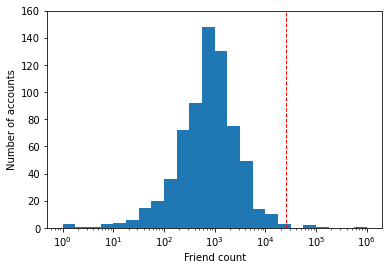

In [115]:
ax = friend_lookup_df['friends_count'].hist(bins=np.logspace(0,6,25))
ax.set_xscale('log')
ax.set_ylim((0,160))
ax.grid(None)
ax.set_xlabel('Friend count')
ax.set_ylabel('Number of accounts')
ax.axvline(25000,c='r',ls='--',lw=1)
ax.set_facecolor('white')
plt.savefig('friends_friend_count.png',dpi=300)

In [148]:
# Accounts that have more than 25k friends that we will want to skip
gt25k_friends = friend_lookup_df.loc[friend_lookup_df['friends_count'] > 25000,'id'].values.tolist()

In [26]:
# Who has a lot of friends?
friend_lookup_df.loc[friend_lookup_df['friends_count'] > 25000,'screen_name']

82      BarackObama
228    trish_zornio
349        505Nomad
392    amyklobuchar
Name: screen_name, dtype: object

In [25]:
# How many accounts have fewer than 25k friends?
len(friend_lookup_df.loc[friend_lookup_df['friends_count'] < 25000,'screen_name'])

688

In [386]:
# Who has more than 5k friends?
friend_lookup_df.loc[friend_lookup_df['friends_count'] > 5000,'screen_name']

2        mitchellbyars
4           SarahdawnH
5            ericmbudd
39             unicorn
62      PortiaColorado
73          jaredpolis
82         BarackObama
110          cprwarner
134          KyleClark
206      shannonrwatts
207        ClimateWest
224          Hegemommy
228       trish_zornio
232               mdy1
263               ACLU
306           COSenDem
324    elephantjournal
338         ehernandez
339     quantum_graeme
349           505Nomad
351         TeamPelosi
352        waylonlewis
362         IronStache
372          tomhigley
392       amyklobuchar
393     bestofnextdoor
396      HC_Richardson
419      aliciawallace
446    allontheline_co
483            tedlieu
493     RandiMcCallian
507      RogerPielkeJr
519      ShannonMarcom
524         leestorrow
566    DanielleMorrill
678           ErinHott
689           cmclymer
Name: screen_name, dtype: object

In [ ]:
# Accounts that are protected that we will want to skip
protected_friends = friend_lookup_df.loc[friend_lookup_df['protected'],'id'].tolist()

## Get friends-of-friends

For each unique friend, get their friends from from the [GET friends/ids](https://developer.twitter.com/en/docs/twitter-api/v1/accounts-and-users/follow-search-get-users/api-reference/get-friends-ids) API endpoint. This will take something like 11 hours.

In [164]:
# Make a function to handle retrieving paginated friend requests
def get_friend_ids(user_id):
    cursor = -1
    friends_ids = []

    while cursor != 0:
        response = api.friends.ids(user_id=user_id,count=5000,cursor=cursor)

        if len(response['ids']) > 0:
            friends_ids += response['ids']

        cursor = response['next_cursor']

    return friends_ids

In [110]:
# Empty container with friend information
friends_d = {}

# Add friend information from members and candidates
friends_d.update(member_friend_ids)
friends_d.update(candidate_friend_ids)

In [202]:
for friend_id in gt1_friends:
    
    # Check to make sure the friend ID isn't already in the dictionary and is not a high-friend account
    if str(friend_id) not in friends_d.keys() and str(friend_id) not in gt25k_friends and str(friend_id) not in protected_friends:
        
        # Try to get the account's friends
        try:
            friends_d[friend_id] = get_friend_ids(friend_id)
            
        # If you get a TwitterError, assume its a rate limit problem
        except twitter.TwitterError:
            
            # Get the current rate limit status
            reset_time = api.application.rate_limit_status()['resources']['friends']['/friends/ids']['reset']
            
            # Wait until the API limit refreshed and add a second for good measure
            sleep_time = (datetime.fromtimestamp(reset_time) - datetime.now())/timedelta(seconds=1) + 1
            
            # Print out to make sure
            print("At {0}, sleeping for {1:.0} seconds.".format(datetime.now(),sleep_time))
            
            # Sleep until our API limit refreshes
            time.sleep(sleep_time)
            
            # Try to get the friend ID again
            friends_d[friend_id] = get_friend_ids(friend_id)
        
        # Break for interrupts
        except KeyboardInterrupt:
            
            break
            
        # Otherwise print out friend_ids and move on
        except:
            
            print("Error on {0}".format(friend_id))
            pass
            
    # Write the friend IDs out to disk after each friend ID
    with open('boulder_city_council_twitter_friends.json','w') as f:
        json.dump(friends_d,f)

At 2021-09-12 14:24:14.037128, sleeping for 732.962872 seconds.
At 2021-09-12 14:36:34.025565, sleeping for 892.974435 seconds.
At 2021-09-12 14:51:34.075787, sleeping for 892.924213 seconds.
At 2021-09-12 15:06:34.317024, sleeping for 892.682976 seconds.
At 2021-09-12 15:21:34.429544, sleeping for 892.570456 seconds.
At 2021-09-12 15:36:34.476258, sleeping for 892.523742 seconds.
At 2021-09-12 15:51:34.176109, sleeping for 892.823891 seconds.
At 2021-09-12 16:06:34.369969, sleeping for 892.630031 seconds.
At 2021-09-12 16:21:34.651259, sleeping for 892.348741 seconds.
At 2021-09-12 16:36:35.039004, sleeping for 891.960996 seconds.
At 2021-09-12 16:51:34.333346, sleeping for 892.666654 seconds.
At 2021-09-12 17:14:34.920677, sleeping for 892.079323 seconds.
At 2021-09-12 17:29:36.080106, sleeping for 890.919894 seconds.
At 2021-09-12 17:44:35.857671, sleeping for 891.142329 seconds.
At 2021-09-12 17:59:36.288149, sleeping for 890.711851 seconds.
At 2021-09-12 18:14:36.612142, sleeping 

In [203]:
len(friends_d)

684

In [220]:
# Repair the data to get the friend IDs rather than the full payloads
repaired_friends_d = {}

for k,v in friends_d.items():
    try:
        repaired_friends_d[k] = v['ids']
        
    except:
        repaired_friends_d[k] = v

In [300]:
# Some of these may be empty
for _id,_l in repaired_friends_d.items():
    if type(_l) != list:
        print(_id)

In [350]:
# Write to disk
with open('boulder_city_council_twitter_friends_repaired.json','w') as f:
    json.dump(repaired_friends_d,f)

## Get information about friends-of-friends

In [27]:
# Open the friend-of-friend data
with open('boulder_city_council_twitter_friends_repaired.json','r') as f:
    repaired_friends_d = json.load(f)

In [28]:
# Count the unique number of friends-of-friends
fof_ids = list(set([str(_id2) for _id, _id_l in repaired_friends_d.items() for _id2 in _id_l]))
len(fof_ids)

448603

In [29]:
# 
fof_ids_counts = pd.Series([str(_id2) for _id, _id_l in repaired_friends_d.items() for _id2 in _id_l]).value_counts()
fof_ids_counts_gt2 = fof_ids_counts[fof_ids_counts > 1].index.tolist()
len(fof_ids_counts_gt2)

116947

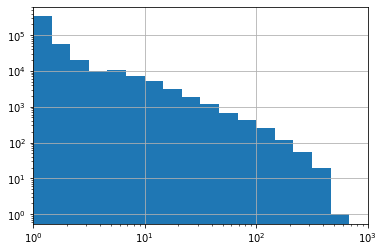

In [47]:
ax = fof_ids_counts.hist(bins=np.logspace(-1,3,25))
ax.set_xlim((1e0,1e3))
ax.set_xscale('log')
ax.set_yscale('log')

In [251]:
fof_lookup_l = []
fof_lookup_d_errors = []

In [252]:
for _chunk in chunks(fof_ids_counts_gt2,n=100):
    try:
        fof_lookup_l += api.users.lookup(user_id=','.join(_chunk))
        
    # If you get a TwitterError, assume its a rate limit problem
    except twitter.TwitterError:

        # Get the current rate limit status
        reset_time = api.application.rate_limit_status()['resources']['users']['/users/lookup']['reset']

        # Wait until the API limit refreshed and add a second for good measure
        sleep_time = (datetime.fromtimestamp(reset_time) - datetime.now())/timedelta(seconds=1) + 1

        # Print out to make sure
        print("At {0.year}-{0.month:02d}-{0.day:02d} {0.hour:02d}:{0.minute:02d}:{0.second:02d}, sleeping for {1:3.0f} seconds.".format(datetime.now(),sleep_time))

        # Sleep until our API limit refreshes
        time.sleep(sleep_time)

        # Try to get the friend ID again
        fof_lookup_l += api.users.lookup(user_id=','.join(_chunk))
        
    except KeyboardInterrupt:
        break
        
    except:
        fof_lookup_d_errors.append(_id_list)
        pass

At 2021-09-13 09:32:38, sleeping for 105 seconds.


TwitterHTTPError: Twitter sent status 429 for URL: 1.1/users/lookup.json using parameters: (oauth_consumer_key=2sqhiRWws5u4UsI2ekwSIHvNl&oauth_nonce=7223411657708000767&oauth_signature_method=HMAC-SHA1&oauth_timestamp=1631547264&oauth_token=16629994-cCldrjyp2Z9Ke5ufXjxsKsh6uH6Sl3dqzFpRuRVEV&oauth_version=1.0&user_id=2905444113%2C65051324%2C4851532317%2C118816810%2C295876766%2C1267667710512676864%2C30513693%2C2334732225%2C3227767206%2C827549356630929409%2C1877990904%2C17719869%2C34635522%2C464158760%2C1304110231%2C41018850%2C910689345669156864%2C1117528086%2C14227394%2C8217092%2C480122241%2C945718481646792704%2C42539727%2C30284449%2C566791381%2C43040748%2C2433737418%2C15756595%2C22682918%2C143612515%2C241007239%2C2870953361%2C963723824%2C10085872%2C977348811336007680%2C87755632%2C14239222%2C2685484890%2C1175681399929442305%2C17628900%2C27397561%2C508078401%2C2571984037%2C785919391%2C389629675%2C983194001397313536%2C2290950254%2C27777722%2C15738250%2C409710216%2C1292788718%2C93900504%2C20291015%2C94993905%2C780376451677884417%2C19424603%2C20813781%2C23455653%2C160977683%2C14748512%2C3005180361%2C16712082%2C293176762%2C295145828%2C456086951%2C1588841%2C14145823%2C940370169859321856%2C24574409%2C1046136380647067648%2C1073722495788830720%2C1022687364806782976%2C27819475%2C28436071%2C956391181%2C3318106141%2C559485977%2C508041167%2C291462147%2C3059537248%2C17101040%2C15347711%2C36670345%2C7756672%2C783837%2C316855289%2C34041217%2C2565569690%2C809233214%2C55645519%2C2313950822%2C999794802420989952%2C115730371%2C1208995453%2C71278096%2C20934583%2C1648615956%2C399452621%2C345401648%2C1656547188&oauth_signature=Lkpnsz8q%2Bj0Gy5YkfJ5lZKxOjR0%3D)
details: {'errors': [{'message': 'Rate limit exceeded', 'code': 88}]}

In [253]:
len(fof_lookup_l)

89384

In [256]:
for _chunk in chunks(fof_ids_counts_gt2[89384:],n=100):
    try:
        fof_lookup_l += api.users.lookup(user_id=','.join(_chunk))
        
    # If you get a TwitterError, assume its a rate limit problem
    except twitter.TwitterError:

        # Get the current rate limit status
        reset_time = api.application.rate_limit_status()['resources']['users']['/users/lookup']['reset']

        # Wait until the API limit refreshed and add a second for good measure
        sleep_time = (datetime.fromtimestamp(reset_time) - datetime.now())/timedelta(seconds=1) + 1

        # Print out to make sure
        print("At {0.year}-{0.month:02d}-{0.day:02d} {0.hour:02d}:{0.minute:02d}:{0.second:02d}, sleeping for {1:3.0f} seconds.".format(datetime.now(),sleep_time))

        # Sleep until our API limit refreshes
        time.sleep(sleep_time)

        # Try to get the friend ID again
        fof_lookup_l += api.users.lookup(user_id=','.join(_chunk))
        
    except KeyboardInterrupt:
        break
        
    except:
        fof_lookup_d_errors.append(_id_list)
        pass

In [364]:
fof_lookup_df = pd.DataFrame(fof_lookup_l).drop_duplicates(subset=['id'])

fof_lookup_df = fof_lookup_df[['id','name','screen_name','location','description','protected','followers_count',
                               'friends_count','created_at','favourites_count','verified','statuses_count','suspended']]

fof_lookup_df['id'] = fof_lookup_df['id'].astype(str)

print(len(fof_lookup_df))

fof_lookup_df.to_csv('friend_of_friend_lookup.csv',index=False)

fof_lookup_df.head()

116931


,id,name,screen_name,location,description,protected,followers_count,friends_count,created_at,favourites_count,verified,statuses_count,suspended
0,1857870864,Aaron Brockett,AaronBrockett12,"Boulder, CO","Parent, spouse, software developer. Member of ...",False,2235,1464,Thu Sep 12 16:43:01 +0000 2013,44325,False,7289,NaN
1,14504258,Daily Camera,dailycamera,"Boulder, Colo.","The Daily Camera newspaper in Boulder, Colo., ...",False,95167,1207,Thu Apr 24 01:16:03 +0000 2008,353,True,95586,NaN
2,43194865,Eric Budd,ericmbudd,"Boulder, Colorado",the econ side of everything. board/team @bould...,False,7363,10000,Thu May 28 20:57:54 +0000 2009,382651,True,124047,NaN
3,117004374,Mitchell Byars,mitchellbyars,"Boulder, CO via Kona, Hawaii",Crime and breaking news/social media/web @dail...,False,22905,16357,Wed Feb 24 07:00:45 +0000 2010,5249,True,50919,NaN
4,16666502,City of Boulder,bouldercolorado,"Boulder, Colorado",The City of Boulder municipal government has s...,False,91188,308,Thu Oct 09 14:08:38 +0000 2008,4173,True,19911,NaN


## Make a network

In [54]:
fof_lookup_df = pd.read_csv('friend_of_friend_lookup.csv')
print(len(fof_lookup_df))
fof_lookup_df.head()

116931


C:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,name,screen_name,location,description,protected,followers_count,friends_count,created_at,favourites_count,verified,statuses_count,suspended
0,1857870864,Aaron Brockett,AaronBrockett12,"Boulder, CO","Parent, spouse, software developer. Member of ...",False,2235,1464,Thu Sep 12 16:43:01 +0000 2013,44325,False,7289,NaN
1,14504258,Daily Camera,dailycamera,"Boulder, Colo.","The Daily Camera newspaper in Boulder, Colo., ...",False,95167,1207,Thu Apr 24 01:16:03 +0000 2008,353,True,95586,NaN
2,43194865,Eric Budd,ericmbudd,"Boulder, Colorado",the econ side of everything. board/team @bould...,False,7363,10000,Thu May 28 20:57:54 +0000 2009,382651,True,124047,NaN
3,117004374,Mitchell Byars,mitchellbyars,"Boulder, CO via Kona, Hawaii",Crime and breaking news/social media/web @dail...,False,22905,16357,Wed Feb 24 07:00:45 +0000 2010,5249,True,50919,NaN
4,16666502,City of Boulder,bouldercolorado,"Boulder, Colorado",The City of Boulder municipal government has s...,False,91188,308,Thu Oct 09 14:08:38 +0000 2008,4173,True,19911,NaN


In [51]:
friends_id_sns_d = {str(k):v for k,v in fof_lookup_df[['id','screen_name']].set_index('id')['screen_name'].to_dict().items()}

In [53]:
g = nx.DiGraph()

for _id1, _id_l in repaired_friends_d.items():
    for _id2 in _id_l:
        if str(_id2) in repaired_friends_d.keys():
            try:
                _id1_sn = friends_id_sns_d[str(_id1)].lower()
                _id2_sn = friends_id_sns_d[str(_id2)].lower()
                g.add_edge(_id1_sn,_id2_sn)
            except:
                pass
            
print("There are {0:,} nodes and {1:,} edges.".format(g.number_of_nodes(), g.number_of_edges()))

print("The density is: {0:.3f}".format(nx.density(g)))

There are 683 nodes and 63,697 edges.
The density is: 0.137


Add Jaccard scores.

In [58]:
def in_jaccard_scores(g,i,j):
    _intersection = set(g.pred[i]) & set(g.pred[j])
    _union = set(g.pred[i]) | set(g.pred[j])
    
    if len(_union) > 0:
        return len(_intersection) / len(_union)
    else:
        return 0

def out_jaccard_scores(g,i,j):
    _intersection = set(g.succ[i]) & set(g.succ[j])
    _union = set(g.succ[i]) | set(g.succ[j])
    
    if len(_union) > 0:
        return len(_intersection) / len(_union)
    else:
        return 0

In [62]:
in_jaccard_scores(g,'jaredpolis','bkeegan')

0.1531322505800464

In [63]:
out_jaccard_scores(g,'jaredpolis','bkeegan')

0.26785714285714285

In [59]:
for i,j,d in g.edges(data=True):
    d['in_jaccard'] = in_jaccard_scores(g,i,j)
    d['out_jaccard'] = out_jaccard_scores(g,i,j)

Add node attributes.

In [384]:
g_nodes_lookup_df = friend_lookup_df[friend_lookup_df['screen_name'].str.lower().isin(g.nodes())].copy()

g_nodes_lookup_df['created_at'] = pd.to_datetime(g_nodes_lookup_df['created_at']).dt.year

g_nodes_lookup_list = g_nodes_lookup_df.to_dict('records')

g_nodes_lookup_list = [(d['screen_name'].lower(),d) for d in g_nodes_lookup_list]

g.add_nodes_from(g_nodes_lookup_list)

In [385]:
nx.write_gexf(g,'boulder_politics.gexf')

Which council members follow me?

In [78]:
set(dict(g.pred['bkeegan']).keys()) & set([d['account_name'].lower() for m,d in members.items() if d['account_name'] is not None])

{'aaronbrockett12', 'junie4boulder', 'rachelkfriend', 'sampweaver'}

In [79]:
set(dict(g.pred['bkeegan']).keys()) & set([d['account_name'].lower() for m,d in candidates.items() if d['account_name'] is not None])

{'boulderlauren4', 'mbforboulder'}

Make a DataFrame of Jaccard scores.

In [60]:
jaccard_df = pd.DataFrame([{'in_jaccard':d['in_jaccard'],'out_jaccard':d['in_jaccard']} for i,j,d in g.edges(data=True)])
jaccard_df.head()

,in_jaccard,out_jaccard
0,0.013158,0.013158
1,0.061914,0.061914
2,0.009416,0.009416
3,0.039548,0.039548
4,0.186916,0.186916


In [68]:
# How many out-jaccard scores are greater than .33?
len(jaccard_df[jaccard_df['out_jaccard'] > .33]) / len(jaccard_df)

0.09526351319528392

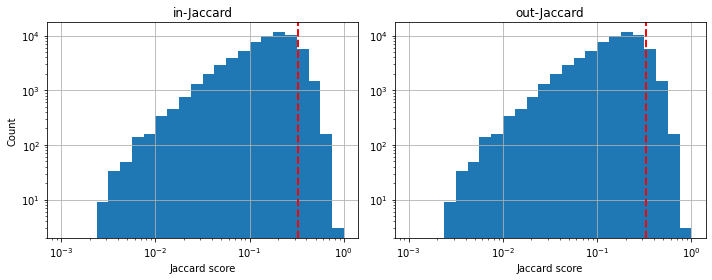

In [116]:
axs = jaccard_df.hist(figsize=(10,4),bins=np.logspace(-3,0,25))
axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,1].set_yscale('log')
axs[0,0].set_ylabel('Count')
axs[0,0].set_xlabel('Jaccard score')
axs[0,1].set_xlabel('Jaccard score')

axs[0,0].axvline(0.33,c='r',lw=2,ls='--')
axs[0,1].axvline(0.33,c='r',lw=2,ls='--')

axs[0,0].set_title('in-Jaccard')
axs[0,1].set_title('out-Jaccard')

ax.set_facecolor('white')

plt.tight_layout()
plt.savefig('jaccard_distribution.png',dpi=300,bbox_inches='tight')

## Key players

### Degree centrality

In-degree centrality.

In [85]:
idc_s = pd.Series({n:c*(len(g) - 1) for n,c in nx.in_degree_centrality(g).items()})
idc_s.sort_values(ascending=False).head(10)

aaronbrockett12    529.0
dailycamera        463.0
ericmbudd          461.0
mitchellbyars      460.0
bouldercolorado    459.0
shayshinecastle    448.0
alex_burness       412.0
jaredpolis         411.0
rachelkfriend      404.0
bouldercounty      367.0
dtype: float64

Out-degree centrality.

In [86]:
odc_s = pd.Series({n:c*(len(g) - 1) for n,c in nx.out_degree_centrality(g).items()})
odc_s.sort_values(ascending=False).head(10)

aaronbrockett12    565.0
boulderbedrooms    532.0
lsweeneymiran      492.0
newr_boulder       435.0
rockymntnpols      434.0
sarahdawnh         415.0
abetterboulder     398.0
cprwarner          376.0
boulderprogress    375.0
liz_marasco        369.0
dtype: float64

Weighted in-degree.

In [98]:
def weighted_out_degree(g,weight):
    wod = {}
    for node in g.nodes():
        sum_weights = sum([d[weight] for n,d in g.succ[node].items()])
        num_neighbors = len(g.succ[node])
        if num_neighbors > 0:
            wod[node] = sum_weights / num_neighbors
        else:
            wod[node] = 0
            
    return wod

In [102]:
pd.Series(weighted_out_degree(g,'in_jaccard')).sort_values(ascending=False).head(10)

vp               0.578730
joebiden         0.572623
whitehouse       0.563868
potus            0.533377
michelleobama    0.513021
kamalaharris     0.478433
senwarren        0.451268
ewarren          0.421512
coloradosun      0.415169
neiltyson        0.403704
dtype: float64

### Betweenness centrality

In [87]:
bc_s = pd.Series(nx.betweenness_centrality(g))
bc_s.sort_values(ascending=False).head(10)

aaronbrockett12    0.089409
boulderbedrooms    0.029283
ericmbudd          0.025633
abetterboulder     0.024799
junie4boulder      0.022152
rachelkfriend      0.021230
cprwarner          0.021162
lsweeneymiran      0.019784
mitchellbyars      0.019737
boulderprogress    0.016174
dtype: float64

### Closeness centrality

In [88]:
cc_s = pd.Series(nx.closeness_centrality(g))
cc_s.sort_values(ascending=False).head(10)

aaronbrockett12    0.765248
ericmbudd          0.715068
dailycamera        0.711956
mitchellbyars      0.711182
bouldercolorado    0.707338
shayshinecastle    0.695311
jaredpolis         0.682260
rachelkfriend      0.678721
alex_burness       0.675917
govofco            0.654287
dtype: float64

### Eigenvector centrality

In [89]:
ec_s = pd.Series(nx.eigenvector_centrality(g))
ec_s.sort_values(ascending=False).head(10)

aaronbrockett12    0.127497
dailycamera        0.123659
mitchellbyars      0.121997
bouldercolorado    0.116513
jaredpolis         0.115543
ericmbudd          0.115326
alex_burness       0.113954
shayshinecastle    0.113711
kcbecker           0.104815
bouldercounty      0.102910
dtype: float64

### All centralities

In [104]:
centrality_df = pd.DataFrame({
    'In-degree': idc_s,
    'Out-degree': odc_s,
    'Betweenness': bc_s,
    'Closeness': cc_s,
    'Eigenvector': ec_s
})

centrality_df.to_csv('centralities.csv')

centrality_df.head()

,In-degree,Out-degree,Betweenness,Closeness,Eigenvector
aaronbrockett12,529.0,565.0,0.089409,0.765248,0.127497
adamfennel,10.0,59.0,0.000024,0.459794,0.006050
ridiculeslie,37.0,33.0,0.000038,0.471389,0.016554
lindakeyesmd,7.0,50.0,0.000006,0.453422,0.004834
quantum_graeme,23.0,87.0,0.000108,0.458506,0.008227
